# Fit bambi model to males and females combined

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from itertools import product
from toolz import reduce, valmap, keyfilter, pluck, curry
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
)
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age <= 90')

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age <= 90')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_mouse_area_df_v00.parquet'
    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]
    return df, sizes_col

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [6]:
df, sizes_col = read_male_ontogeny(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

df['sex'] = np.where(sex_id == 1)[0]
df = df.set_index('sex', append=True)

In [64]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    "mice": sex_id,
}

age_sd = 0.03

hypparams = {
    "log_age": True,
    "min_age": 3,
    "max_age": 130,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 400,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(sex_id),
    "lr": 0.25,
    "n_opt_iter": 600,
}

In [56]:
mdl = fit_model(features, hypparams, 5)

In [57]:
valmap(np.max, mdl['params'])

{'bio_basis_weights': 3.9243011,
 'development_weights': 0.23138572,
 'individual_biases': 2.6283805,
 'size_slope': 0.20658094}

In [58]:
valmap(np.min, mdl['params'])

{'bio_basis_weights': -4.356762,
 'development_weights': -2.8502119,
 'individual_biases': -2.065509,
 'size_slope': -0.2007448}

In [59]:
mdl['bio_ages'].min()

3.3977427

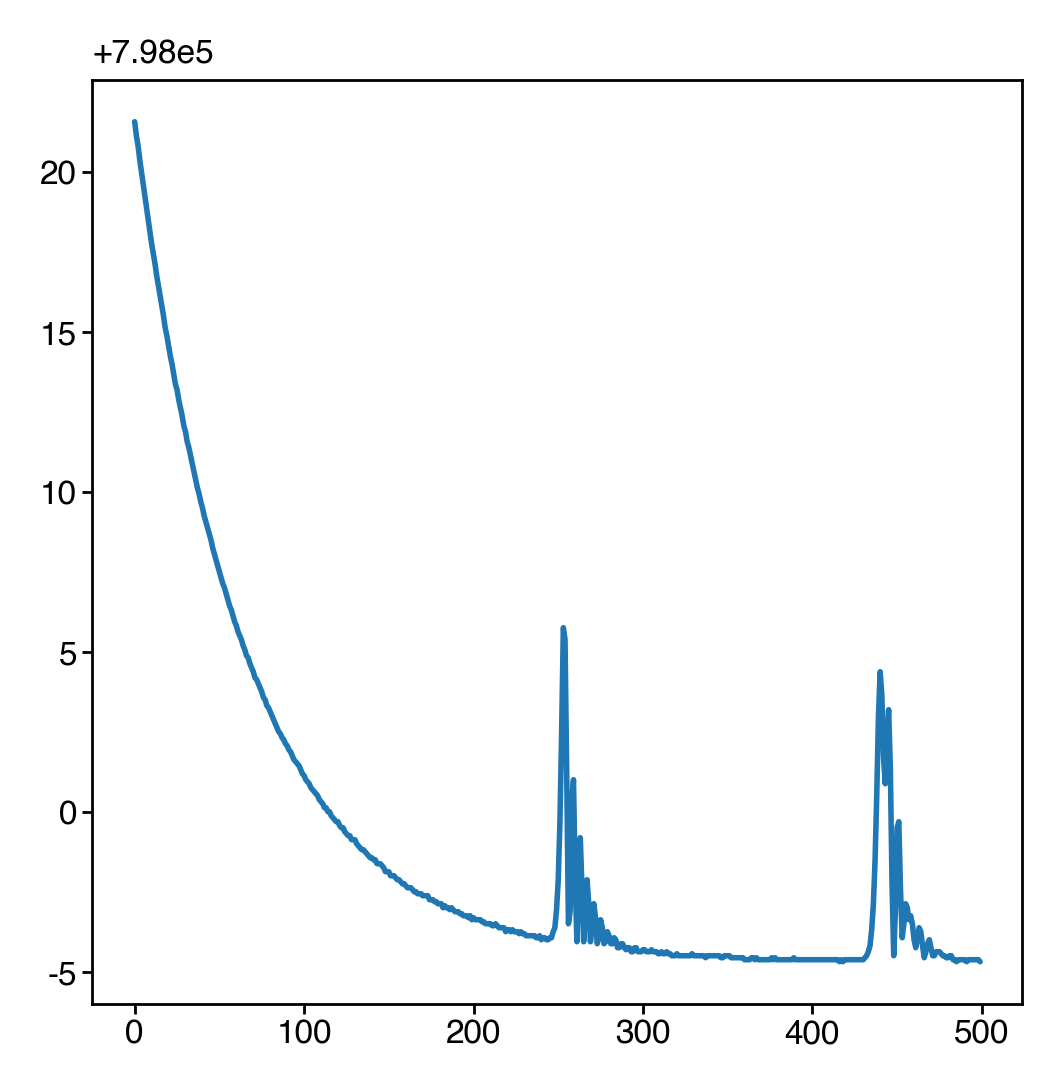

In [61]:
plt.plot(mdl['loss'][200:])

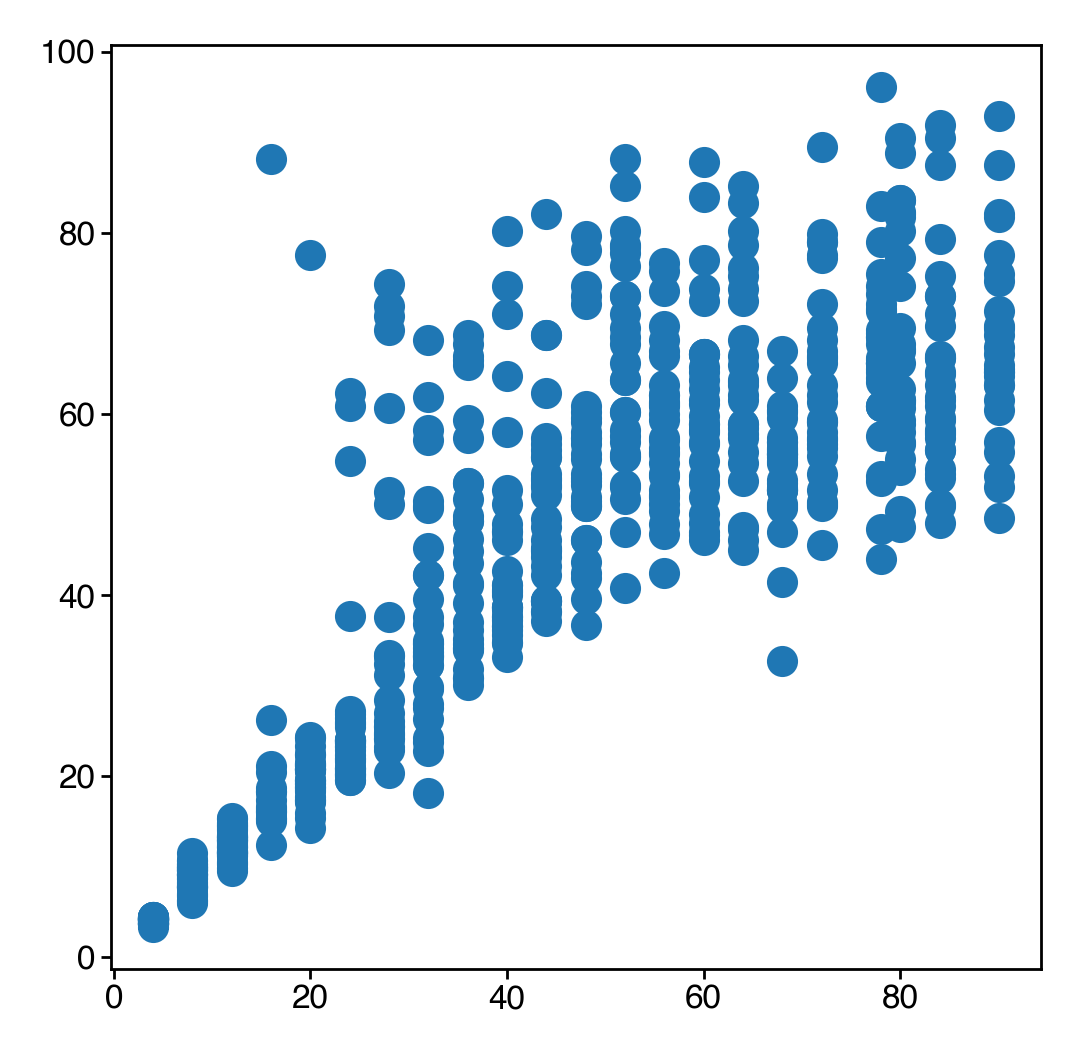

In [62]:
plt.scatter(mdl['true_ages'], mdl['bio_ages'])

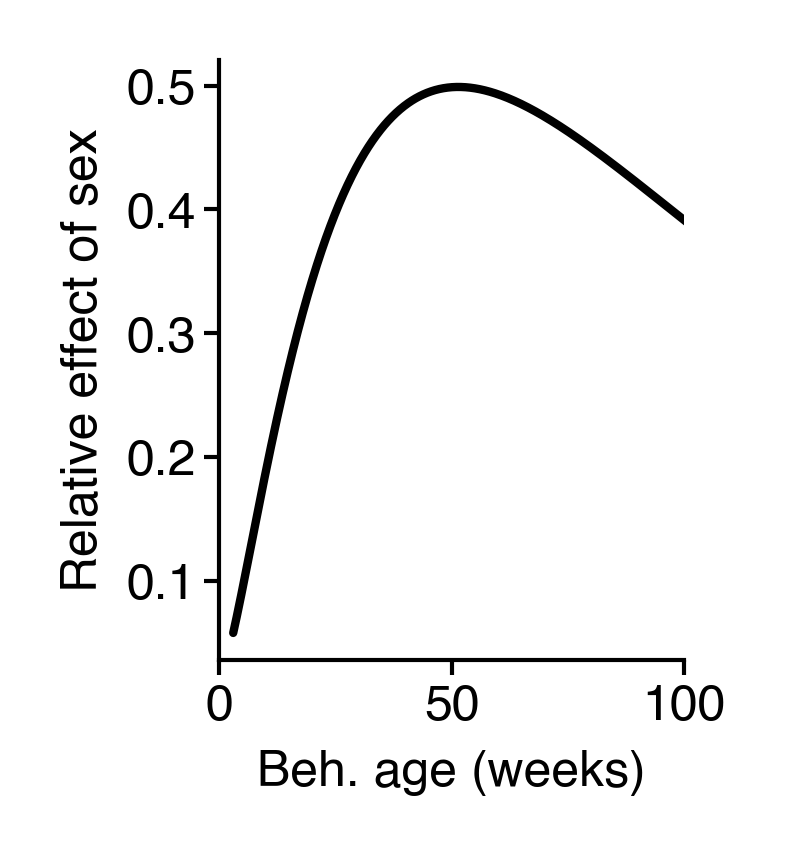

In [63]:
comps = mdl['init_components']

x = mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of sex")
sns.despine()

### Optimize Age SD

In [65]:
keep_keys = ['heldout_ll', 'heldout_r2_total', 'heldout_r2_total_v3', 'true_ages', 'bio_ages', 'log_bio_ages']
keeper = curry(keyfilter)(lambda k: k in keep_keys)

In [66]:
outs = []
predictions = []

for age_sd, n_splines in tqdm(list(product(np.logspace(-2, np.log(0.5), 11), range(4, 7)))):
    hypparams["age_sd"] = float(age_sd)
    hypparams['n_splines'] = int(n_splines)

    try:
        tmp = masked_xval(features, hypparams, 5, n_repeats=3, disable_tqdm=True)
        for k, v in tmp.items():
            v["log_bio_ages"] = v["init_components"].age_normalizer(v["bio_ages"])
        tmp = valmap(keeper, tmp)
        for k, v in tmp.items():
            outs.append(
                {
                    "repeat": k,
                    "age_sd": age_sd,
                    "n_splines": n_splines,
                    "total_resid": np.abs(v["true_ages"] - v["bio_ages"]).mean(),
                    **v,
                }
            )
            predictions.append(
                pd.DataFrame(
                    dict(
                        bio=v["bio_ages"],
                        log_bio=v["log_bio_ages"],
                        chron=v["true_ages"],
                        repeat=k,
                        age_sd=age_sd,
                        n_splines=n_splines,
                    )
                )
            )
            pd.concat(predictions).to_parquet('/n/scratch/users/w/wg41/2024-06-10_ont_bio_age_optimization_predictions.parquet')
    except ValueError:
        print(f'Error {age_sd:0.2f}; {n_splines}')
        pass

outs_df = pd.DataFrame(outs)
predictions = pd.concat(predictions)

  0%|          | 0/33 [00:00<?, ?it/s]

In [10]:
# predictions.to_parquet('/n/scratch/users/w/wg41/2024-06-01_bio_age_optimization_predictions.parquet')

In [ ]:
tmp_out = []
for (age_sd, n_splines), p in predictions.groupby(['age_sd', 'n_splines']):
    fig, ax = plt.subplots(1, p['repeat'].nunique(), sharex=True, sharey=True, figsize=(p['repeat'].nunique() * 1, 1.5))
    for r, _df in p.groupby('repeat'):
        ax[r].scatter(_df['chron'], _df['bio'], s=2, lw=0, c='k')
        monotonicity = ((_df.groupby('chron')['bio'].std().rolling(3, center=True, min_periods=1).mean().diff(2) / 2) > 0).mean()
        median_bio_mae = _df.groupby('chron')['bio'].median().reset_index().diff(axis=1).drop(columns=['chron']).abs().mean()['bio']
        tmp_out.append(dict(mono=monotonicity, mae=median_bio_mae, repeat=r, age_sd=age_sd, n_splines=n_splines))
        ax[r].set(title=f"Monotonic %: {monotonicity:0.2f}\nMedian bio MAE: {median_bio_mae:0.1f}")
    fig.suptitle(f"Age prior: {age_sd:0.1e}; N splines: {n_splines}")
    fig.tight_layout()

In [12]:
tmp_out_df = pd.DataFrame(tmp_out)

<Axes: xlabel='age_sd', ylabel='n_splines'>

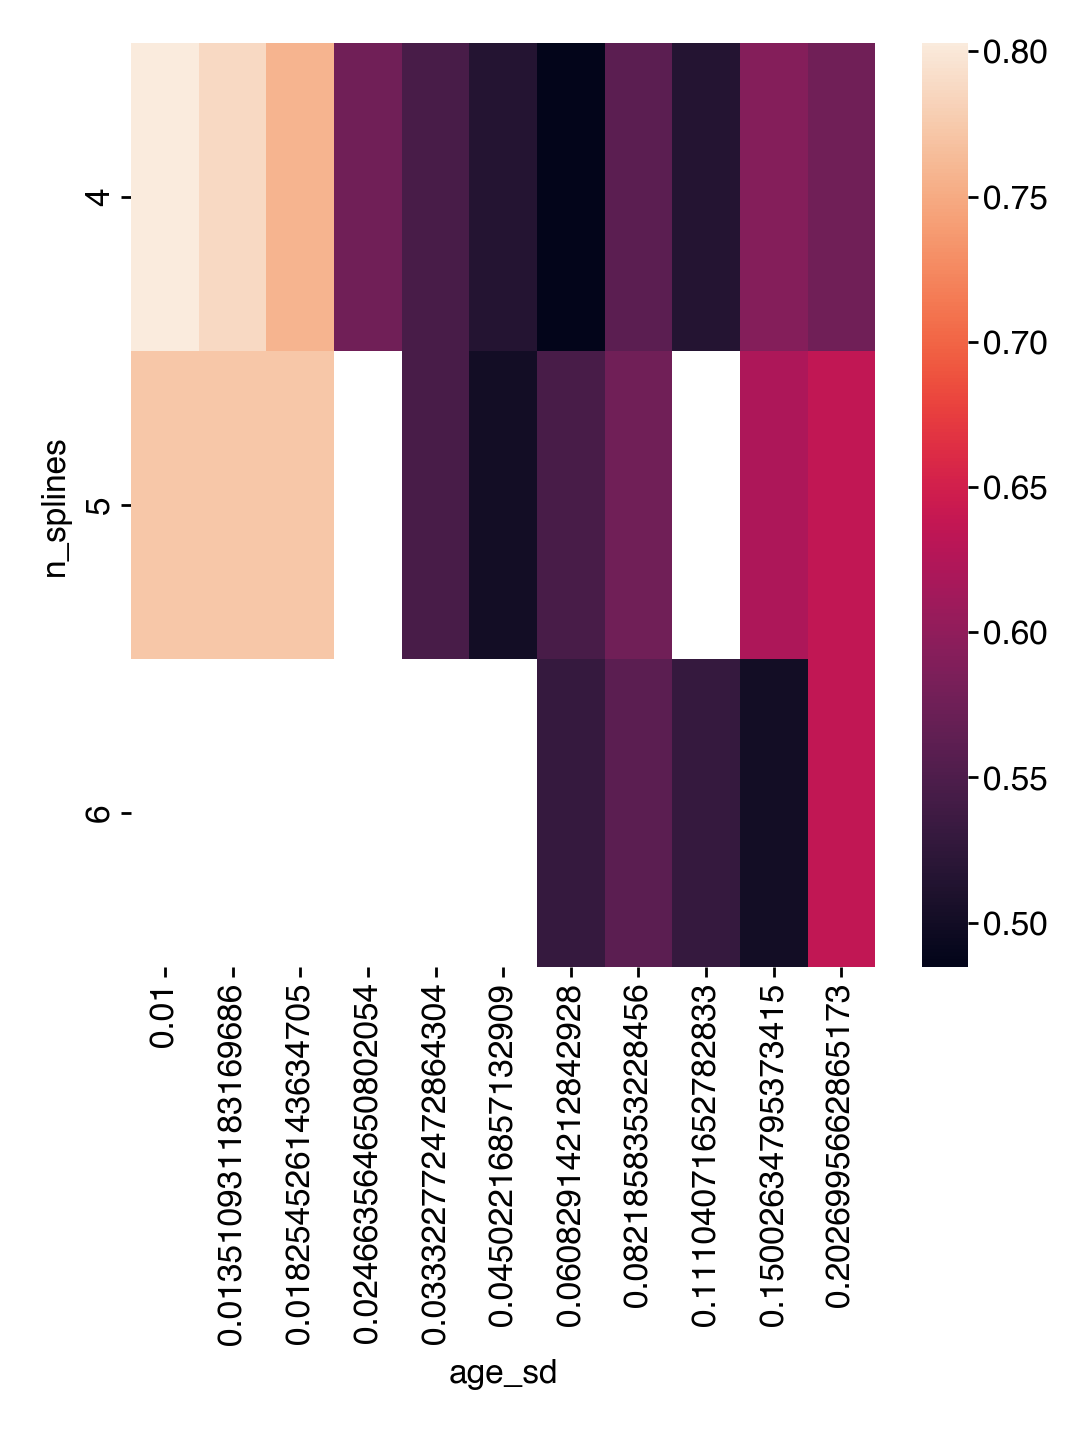

In [13]:
sns.heatmap(tmp_out_df.pivot_table(columns='age_sd', index='n_splines', values='mono'))

[None]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


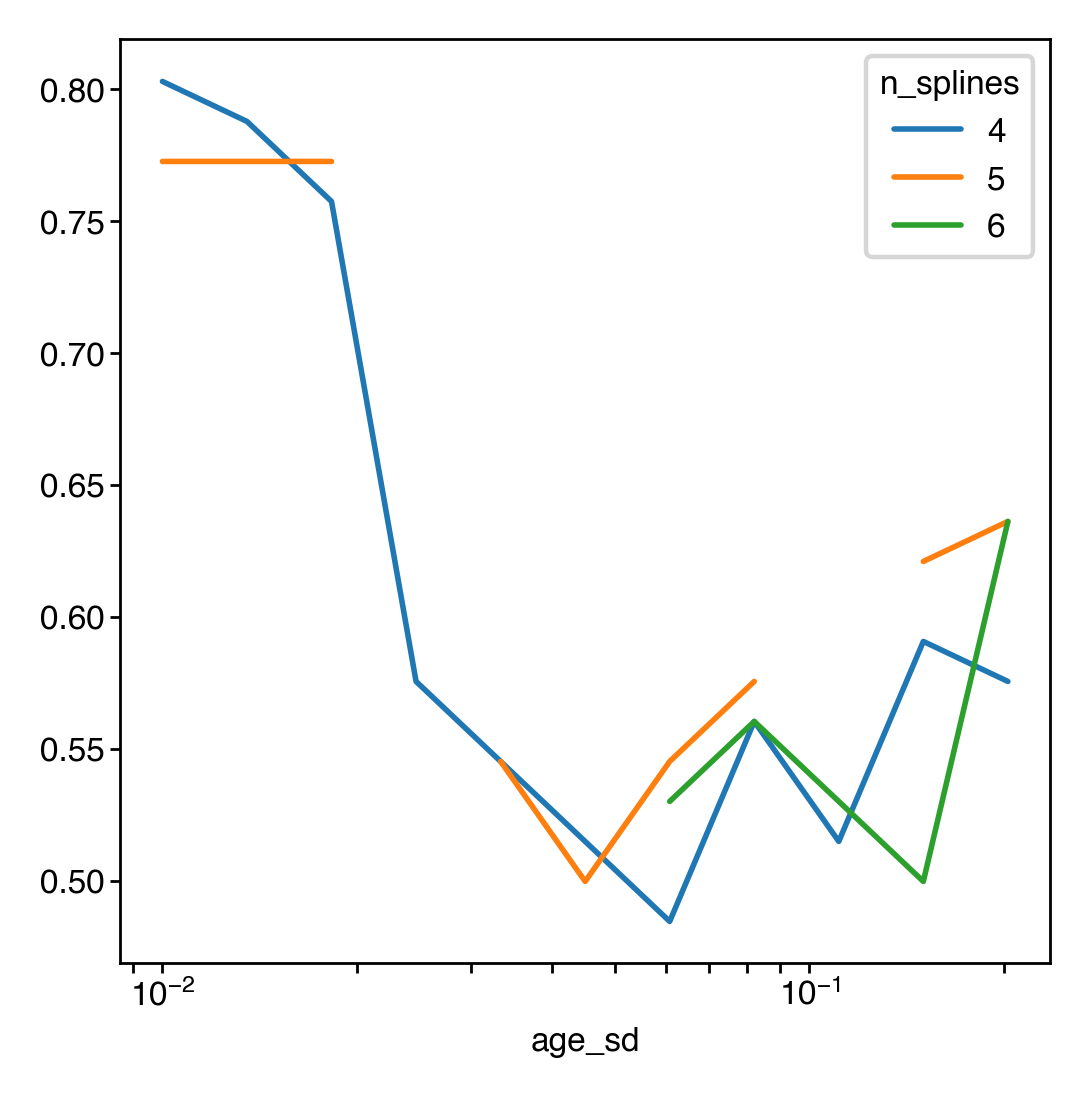

In [14]:
ax = tmp_out_df.pivot_table(index='age_sd', columns='n_splines', values='mono').plot()
ax.set(xscale='log')

<Axes: xlabel='age_sd', ylabel='n_splines'>

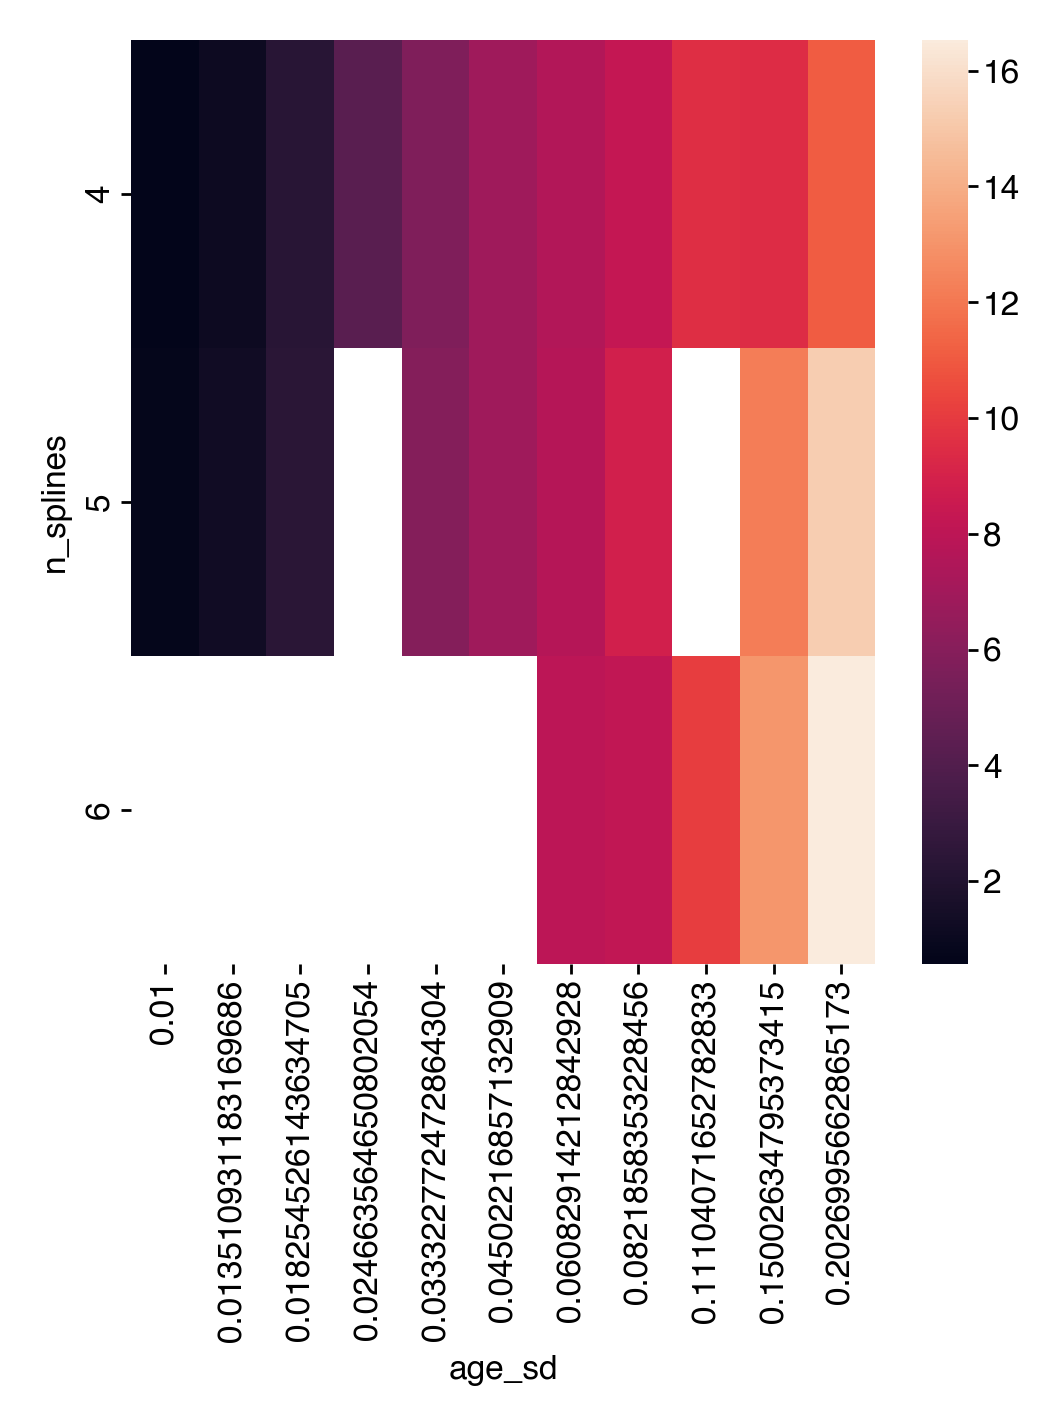

In [15]:
sns.heatmap(tmp_out_df.pivot_table(columns='age_sd', index='n_splines', values='mae'))

[None]

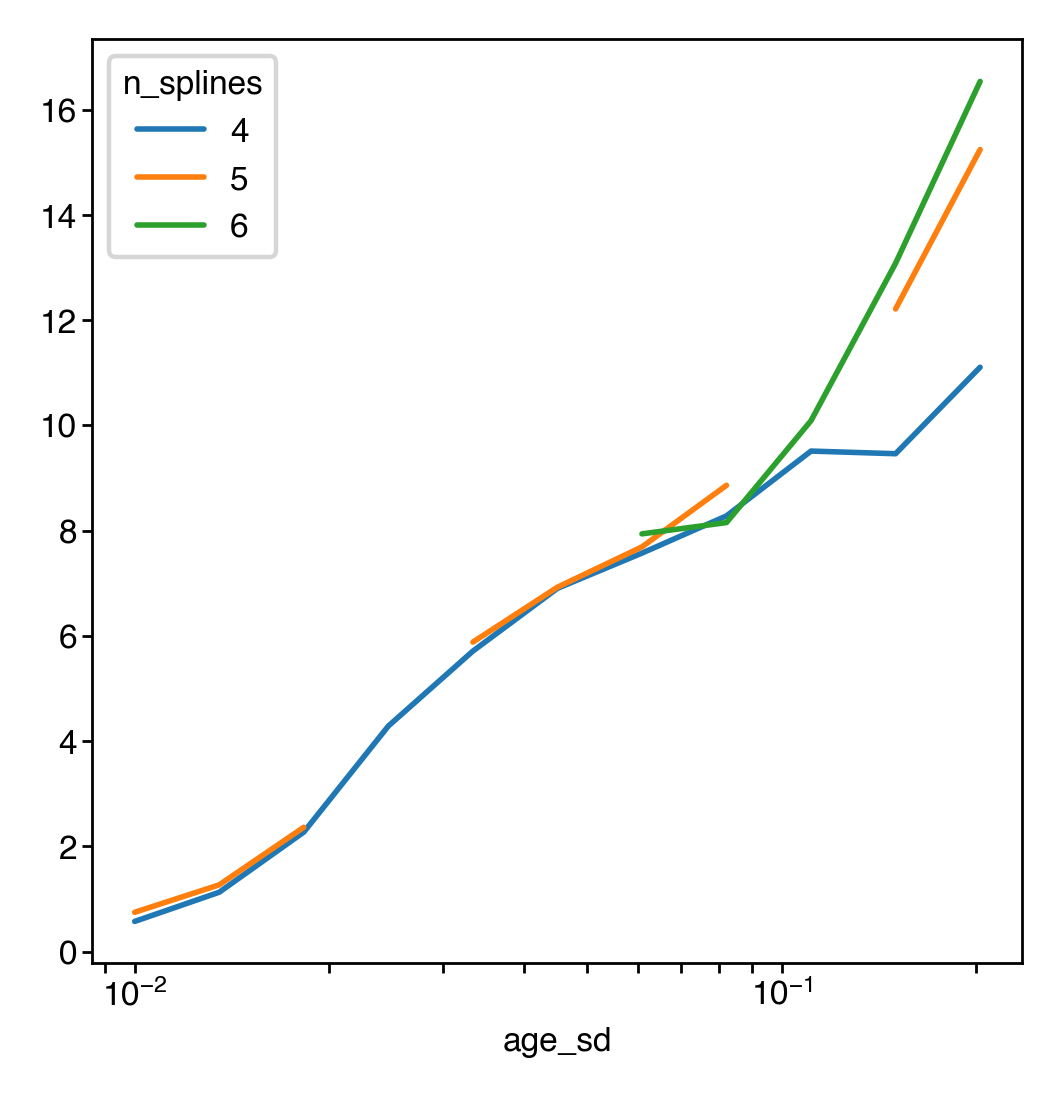

In [16]:
ax = tmp_out_df.pivot_table(index='age_sd', columns='n_splines', values='mae').plot()
ax.set(xscale='log')

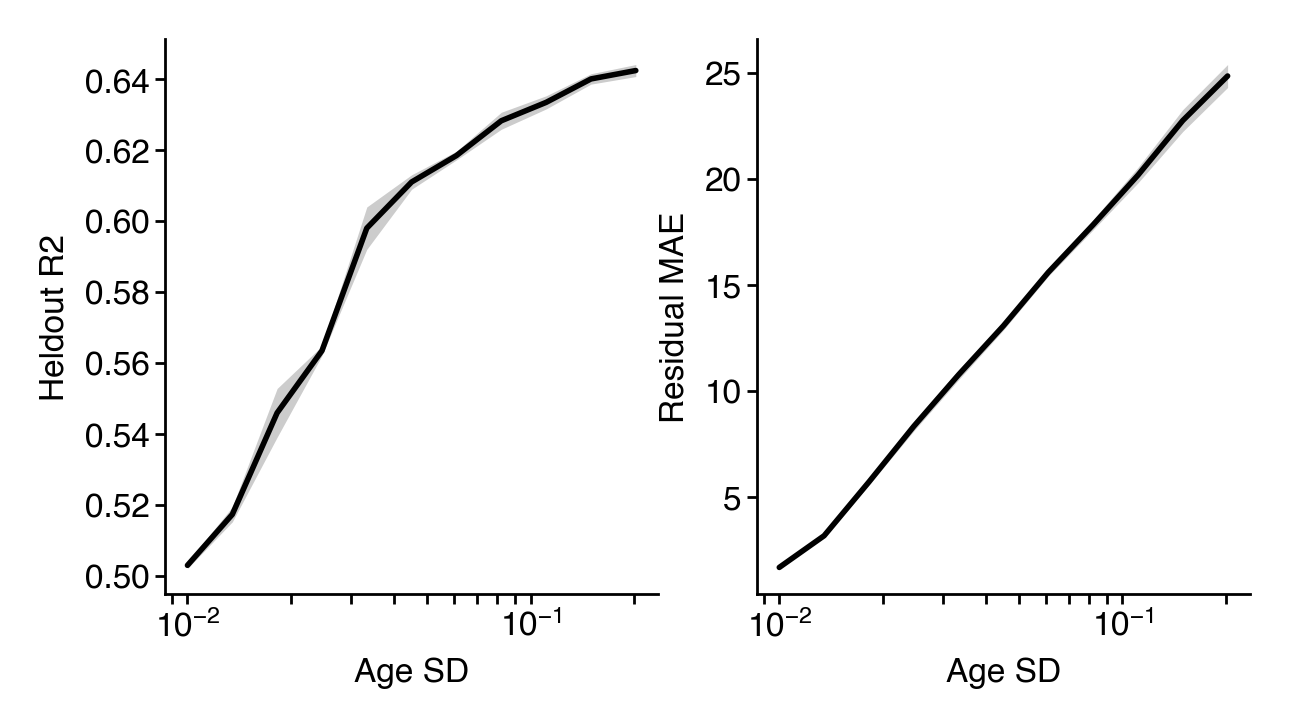

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(3.5, 1.8))
a = sns.lineplot(
    data=outs_df,
    x="age_sd",
    y="heldout_r2_total_v3",
    errorbar="se",
    err_kws=dict(lw=0),
    color="k",
    ax=ax[0],
)
a.set(ylabel="Heldout R2", xlabel="Age SD", xscale='log')
sns.despine()

a = sns.lineplot(
    data=outs_df,
    x="age_sd",
    y="total_resid",
    errorbar="se",
    err_kws=dict(lw=0),
    color="k",
    ax=ax[1],
)
a.set(ylabel="Residual MAE", xlabel="Age SD", xscale='log')
sns.despine()